# *Importing necessary libraries*

In [1]:
import librosa # open wav files
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
import os # operating system via python 
import numpy as np  # linear algebra
import pandas as pd  # CSV file
import scipy.io.wavfile as sci_wav  # Open wav files
import re # Using regex to match

/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
/Users/fernankiwi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


*Loading the wavesounds*

In [2]:
# Defining the global path to wav files
PATH = './cats_dogs/'

In [3]:
# Reading all the list of files in the directory path
def read_file_names(PATH):
    file_name_cats = []
    file_name_dogs = []
    for file_path in os.listdir(PATH):
        if os.path.isfile(os.path.join(PATH, file_path)):
            if 'cat' in file_path:
                file_name_cats.append(file_path)
            elif 'dog' in file_path:
                file_name_dogs.append(file_path)
    return file_name_cats, file_name_dogs

In [4]:
cats_files, dogs_files = read_file_names(PATH)

In [5]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths

    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [librosa.load(PATH + f) for f in wav_files]
    # return [sci_wav.read(PATH + f)[1] for f in wav_files]

In [6]:
def train_test_split(file_names, split_porcentage=0.2, seed=42):
     np.random.seed(seed) # Set a seed for reproducibility
     n = len(file_names)
     k = int(n * split_porcentage)

     random_permutation = np.random.permutation(n)     
     train = [file_names[i] for i in random_permutation]

     train_file_names = train[:n - k]
     train_wav_file = read_wav_files(train_file_names)

     test_file_names = train[n - k:]
     test_wav_files = read_wav_files(test_file_names)

     return train_file_names, train_wav_file, test_file_names, test_wav_files

In [7]:
# Split train wav's from test wav's
train_cat_names, train_cat_wav, test_cat_names, test_cat_wav = train_test_split(cats_files)
train_dog_names, train_dog_wav, test_dog_names, test_dog_wav = train_test_split(dogs_files)

In [8]:
dataframe = {
     'train_cat': train_cat_wav,
     'train_dog': train_dog_wav,
     'test_cat': test_cat_wav,
     'test_dog': test_dog_wav,
}

In [9]:
def load_dataset(dataframe):
    df = dataframe
    dataset = {}
    for k in ['train_cat', 'train_dog', 'test_cat', 'test_dog']:
        v = np.concatenate([item[0] for item in df[k]], axis=0).astype('float32')

        # Compute mean and variance
        if k == 'train_cat':
            dog_std = dog_mean = 0
            cat_std, cat_mean = v.std(), v.mean()
        elif k == 'train_dog':
            dog_std, dog_mean = v.std(), v.mean()

        # Mean and variance suppression
        std, mean = (cat_std, cat_mean) if 'cat' in k else (dog_std, dog_mean)
        v = (v - mean) / std
        dataset[k] = v

        print('loaded {} with {} sec of audio'.format(k, len(v) / 16000))

    return dataset

In [10]:
load_dataset(dataframe)

loaded train_cat with 1431.456125 sec of audio
loaded train_dog with 660.626 sec of audio
loaded test_cat with 393.0434375 sec of audio
loaded test_dog with 164.100125 sec of audio


{'train_cat': array([-0.00340083, -0.00340083, -0.00340083, ..., -0.07006193,
        -0.36248338, -0.26494327], dtype=float32),
 'train_dog': array([-0.02417978, -0.02697763, -0.02313133, ...,  0.00651677,
         0.01868594,  0.0135517 ], dtype=float32),
 'test_cat': array([-0.00340083, -0.00340083, -0.00340083, ..., -0.00161592,
        -0.00312608, -0.00340083], dtype=float32),
 'test_dog': array([-0.01475155, -0.01616455, -0.01420115, ..., -0.00322242,
        -0.0046466 , -0.00214317], dtype=float32)}

In [46]:
def create_dataframe(file_names, wav_files):
     return pd.DataFrame({
          'file_name': file_names,
          'audio_wav': [item[0] for item in wav_files],
          'length(seconds)': [len(item[0])/item[1] for item in wav_files],
          'number_of_samples': [len(item[0]) for item in wav_files],
          'sample_rate': [item[1] for item in wav_files],
          'max_amplitude': [np.array(item[0]).max() for item in wav_files],
          'min_amplitude': [np.array(item[0]).min() for item in wav_files]
     })

cat_train_df = create_dataframe(train_cat_names, train_cat_wav)
cat_test_df = create_dataframe(test_cat_names, test_cat_wav)
dog_train_df = create_dataframe(train_dog_names, train_dog_wav)
dog_test_df = create_dataframe(test_dog_names, test_dog_wav)

In [43]:
cat_train_df.head()
# cat_train_df['train_cat_wav'][0]

,file_name,audio_wav,length(seconds),number_of_samples,sample_rate,max_amplitude,min_amplitude
0,cat_84.wav,"[1.3545656e-10, -2.2184848e-11, -2.6804926e-11...",9.120000,201096,22050,0.988553,-0.987455
1,cat_68.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.360907,52058,22050,0.916598,-0.995885
2,cat_1.wav,"[0.0036967827, 0.0040170797, 0.0015610287, 6.8...",11.200000,246960,22050,0.834551,-1.031164
3,cat_147.wav,"[0.024267724, 0.029048927, 0.027480468, 0.0294...",12.000000,264600,22050,0.344687,-0.253928
4,cat_33.wav,"[-0.0055221445, -0.0021317091, 0.0021610605, 0...",4.193107,92458,22050,1.011643,-0.919346


In [34]:
dog_test_df.head()

,test_dog_name,test_dog_wav,number_of_samples,sample_rate,max_amplitude,min_amplitude
0,dog_barking_11.wav,"[-0.0017590539, -0.0019561895, -0.001682266, -...",205001,22050,0.956572,-0.997793
1,dog_barking_9.wav,"[-2.9603589e-05, -3.141236e-05, -2.9355077e-05...",38890,22050,0.867343,-0.995093
2,dog_barking_92.wav,"[-0.00032149986, -0.0005554668, -0.00056589936...",249165,22050,0.578467,-0.581965
3,dog_barking_77.wav,"[-1.9376983e-05, -3.2515894e-05, -0.0001455399...",55939,22050,0.863318,-1.001017
4,dog_barking_33.wav,"[-3.1116426e-05, 4.7645976e-06, 6.317729e-05, ...",85177,22050,0.794215,-1.000062


# *Plot some of this waves*

In [20]:
print(cat_train_df['file_name'][10]) # cat_130.wav
plt.figure(figsize=(12, 4))
librosa.display.waveshow(cat_train_df['audio_wav'][10], sr = cat_train_df['sample_rate'][10])
plt.show()

cat_130.wav


In [48]:
print(cat_test_df['file_name'][10]) # cat_29.wav
plt.figure(figsize=(12, 4))
librosa.display.waveshow(cat_test_df['audio_wav'][10], sr = cat_test_df['sample_rate'][10])
plt.show()

cat_29.wav


In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(dog_train_df['audio_wav'][10], sr = dog_train_df['sample_rate'][10])
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(dog_test_df['audio_wav'][10], sr = dog_test_df['sample_rate'][10])
plt.show()

# Time Domain

# Frequency Features
- Amplitude
- Frequency
- Amplitude Envelope
- RMS (ADSR Model)
- Zero Cross Rate

In [ ]:
# Plotting a histogram of the Maximum Amplitude for Cats
plt.hist(cat_train_df['max_amplitude']+cat_test_df['max_amplitude'], bins=20, edgecolor='k')
plt.xlabel('Max Amplitude')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Amplitudes [Cats dataset]')
plt.grid(True)
plt.show()

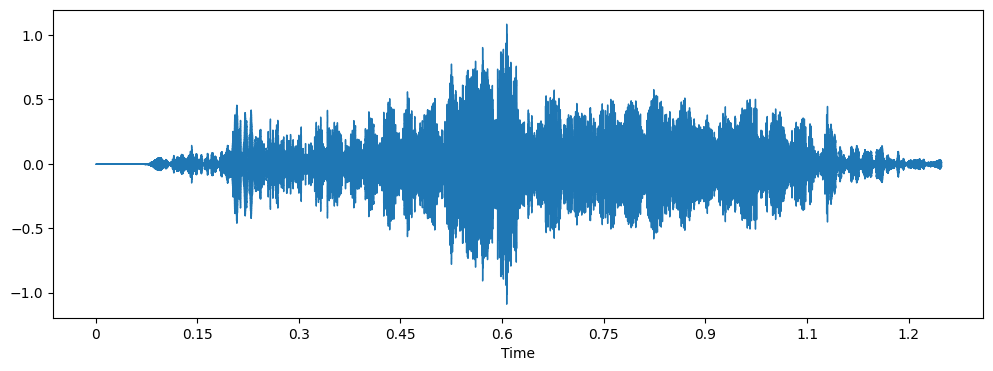

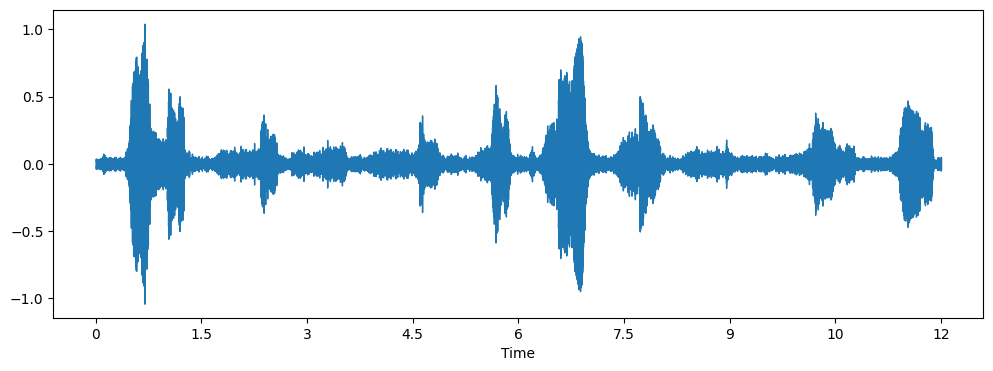

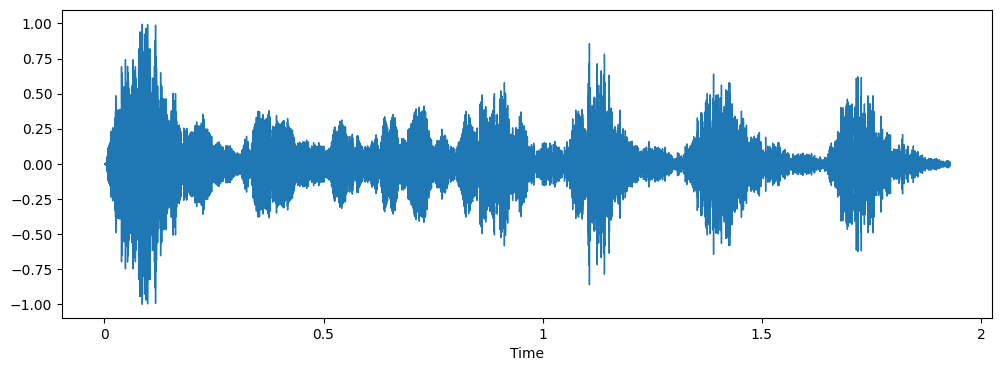

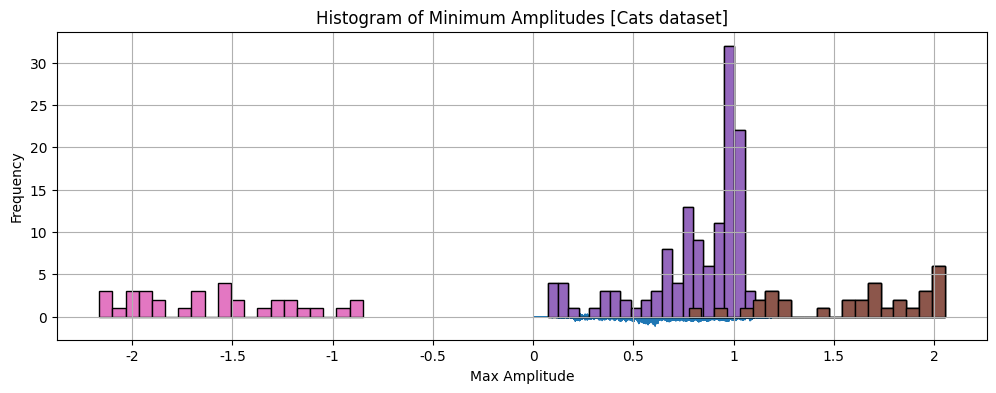

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [55]:
# Plotting a histogram of the Minimum Amplitude for Cats
plt.hist(cat_train_df['min_amplitude']+cat_test_df['min_amplitude'], bins=20, edgecolor='k')
plt.xlabel('Max Amplitude')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum Amplitudes [Cats dataset]')
plt.grid(True)
plt.show()